# Finance clustering 

## Yahoo Finance

In [8]:
import sys

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yfinance as yf

In [9]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [10]:
msft = yf.Ticker("MSFT")
msft.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-11-17,338.940002,342.190002,338.000000,339.119995,19053400,0,0
2021-11-18,338.179993,342.450012,337.119995,341.269989,22463500,0,0
2021-11-19,342.640015,345.100006,342.200012,343.109985,21963400,0,0
2021-11-22,344.619995,349.670013,339.549988,339.829987,31031100,0,0
2021-11-23,337.049988,339.450012,333.559998,337.679993,30427600,0,0
2021-11-24,336.279999,338.160004,333.910004,337.910004,21661300,0,0
2021-11-26,334.350006,337.929993,328.119995,329.679993,24217200,0,0
2021-11-29,334.940002,339.029999,334.739990,336.630005,28563500,0,0
2021-11-30,335.320007,337.779999,328.989990,330.589996,42885600,0,0


## In case you need all tickers

In [11]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [12]:
get_info(msft)

{'shortName': 'Microsoft Corporation',
 'sector': 'Technology',
 'industry': 'Software—Infrastructure',
 'country': 'United States',
 'market': 'us_market'}

In [13]:
import requests


url_link = 'https://finance.yahoo.com/trending-tickers'
r = requests.get(url_link,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
trending = pd.read_html(r.text)[0]
display(trending.head(5))

url_link = 'https://finance.yahoo.com/screener/predefined/most_actives'
r = requests.get(url_link,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
most_active = pd.read_html(r.text)[0]
display(most_active.head(5))

url_link = 'https://finance.yahoo.com/gainers'
r = requests.get(url_link,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
gainers = pd.read_html(r.text)[0]
display(gainers.head(5))

url_link = 'https://finance.yahoo.com/losers'
r = requests.get(url_link,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
losers = pd.read_html(r.text)[0]
display(losers.head(5))


,Symbol,Name,Last Price,Market Time,Change,% Change,Volume,Market Cap,Intraday High/Low,52 Week Range,Day Chart
0,AMD,"Advanced Micro Devices, Inc.",146.50,4:00PM EST,10.90,+8.04%,72.426M,178B,NaN,NaN,NaN
1,RBLX,Roblox Corporation,97.95,4:01PM EST,-9.72,-9.03%,43.177M,55.815B,NaN,NaN,NaN
2,AAPL,Apple Inc.,179.30,4:00PM EST,4.97,+2.85%,131.063M,2.992T,NaN,NaN,NaN
3,ROKU,"Roku, Inc.",203.94,4:00PM EST,-17.61,-7.95%,20.475M,27.001B,NaN,NaN,NaN
4,NVDA,NVIDIA Corporation,304.59,4:00PM EST,21.22,+7.49%,69.831M,189.76B,NaN,NaN,NaN


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,AAPL,Apple Inc.,179.30,4.97,+2.85%,127.001M,87.01M,2.942T,31.96,NaN
1,F,Ford Motor Company,20.19,0.14,+0.70%,76.081M,93.177M,80.684B,28.32,NaN
2,NIO,NIO Inc.,30.79,-1.51,-4.67%,78.8M,40.78M,48.974B,NaN,NaN
3,PFE,Pfizer Inc.,58.80,3.26,+5.87%,73.318M,35.386M,330.037B,16.80,NaN
4,AMD,"Advanced Micro Devices, Inc.",146.50,10.90,+8.04%,71.982M,53.127M,176.915B,45.19,NaN


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,CCMP,"CMC Materials, Inc.",195.500,49.5300,+33.93%,5.176M,186295,5.557B,NaN,NaN
1,BMCLF,BAIC Motor Corporation Limited,0.485,0.1018,+26.57%,246270,23119,3.955B,8.66,NaN
2,BRDS,"Bird Global, Inc.",8.970,1.2200,+15.74%,1.073M,1.003M,2.461B,NaN,NaN
3,DNA,"Ginkgo Bioworks Holdings, Inc.",10.850,1.3500,+14.21%,12.876M,8.262M,16.131B,NaN,NaN
4,AI,"C3.ai, Inc.",35.010,3.8300,+12.28%,9.492M,3.364M,3.677B,NaN,NaN


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,WXXWY,WuXi Biologics (Cayman) Inc.,19.83,-5.2300,-20.85%,444302,161096,42.111B,98.17,NaN
1,WUXAY,"WuXi AppTec Co., Ltd.",17.30,-4.1500,-19.35%,118972,14655,56.496B,78.28,NaN
2,LEGN,Legend Biotech Corporation,41.14,-7.4000,-15.25%,2.576M,562459,5.954B,NaN,NaN
3,ZLAB,Zai Lab Limited,54.90,-7.7900,-12.43%,2.701M,594545,5.895B,NaN,NaN
4,EGRNF,China Evergrande Group,0.19,-0.0246,-11.46%,174487,947769,2.623B,1.01,NaN


In [14]:
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
interesting_tickers[:4]

['NUE', 'LMDX', 'WUXAY', 'ITUB']

In [15]:
len(interesting_tickers)

89

In [19]:
full_ticker_data = []

ticker_obj = yf.Ticker('BGNE')
close_price = ticker_obj.history(period='3mo')['Close'].to_dict()
info = get_info(ticker_obj)
info.update(close_price)
full_ticker_data.append(info)
pd.DataFrame(full_ticker_data)

ticker_obj = yf.Ticker('NUE')
close_price = ticker_obj.history(period='3mo')['Close'].to_dict()
info = get_info(ticker_obj)
info.update(close_price)
full_ticker_data.append(info)
pd.DataFrame(full_ticker_data)

,shortName,sector,industry,country,market,2021-09-17 00:00:00,2021-09-20 00:00:00,2021-09-21 00:00:00,2021-09-22 00:00:00,2021-09-23 00:00:00,...,2021-11-29 00:00:00,2021-11-30 00:00:00,2021-12-01 00:00:00,2021-12-02 00:00:00,2021-12-03 00:00:00,2021-12-06 00:00:00,2021-12-07 00:00:00,2021-12-08 00:00:00,2021-12-09 00:00:00,2021-12-10 00:00:00
0,"BeiGene, Ltd.",Healthcare,Biotechnology,Cayman Islands,us_market,403.140015,398.500000,388.510010,388.179993,385.420013,...,343.200012,347.529999,351.980011,345.869995,314.140015,299.209991,317.250000,315.029999,305.600006,298.429993
1,Nucor Corporation,Basic Materials,Steel,United States,us_market,104.477249,96.498764,95.831406,96.797585,99.008850,...,112.070000,106.260002,104.690002,107.559998,110.500000,110.239998,114.010002,112.809998,112.889999,113.209999


In [47]:
full_ticker_data = []

for ticker in tqdm(interesting_tickers):
    try:
        ticker_obj = yf.Ticker(ticker)
        close_price = ticker_obj.history(start="2020-01-01", period='3mo')['Close'].to_dict()
        info = get_info(ticker_obj)
        info.update(close_price)
        full_ticker_data.append(info)
    except:
        continue
        
full_ticker_df = pd.DataFrame(full_ticker_data)

  0%|          | 0/89 [00:00<?, ?it/s]

In [72]:
df_tic = full_ticker_df.dropna(axis=0, thresh = int(0.8*df.shape[0]))
df_tic = pd.concat([df_tic.iloc[:,:5],df_tic.iloc[:,5:].dropna(axis='columns' )],axis=1)
df_tic.head()

,shortName,sector,industry,country,market,2021-06-21 00:00:00,2021-06-25 00:00:00,2021-06-28 00:00:00,2021-06-29 00:00:00,2021-06-30 00:00:00,...,2021-11-16 00:00:00,2021-11-18 00:00:00,2021-11-19 00:00:00,2021-11-23 00:00:00,2021-11-24 00:00:00,2021-11-29 00:00:00,2021-11-30 00:00:00,2021-12-01 00:00:00,2021-12-06 00:00:00,2021-12-07 00:00:00
0,Nucor Corporation,Basic Materials,Steel,United States,us_market,95.076195,95.899406,94.332329,94.257622,95.552505,...,111.699997,111.699997,112.849998,119.379997,115.790001,112.070000,106.260002,104.690002,110.239998,114.010002
1,LumiraDx Limited,Healthcare,Diagnostics & Research,United Kingdom,us_market,9.890000,9.880000,9.880000,9.880000,9.870000,...,9.620000,10.360000,10.350000,9.640000,8.630000,10.060000,9.490000,9.510000,9.080000,9.100000
3,Itau Unibanco Banco Holding SA,Financial Services,Banks—Regional,Brazil,us_market,5.192743,5.022886,4.982444,4.909648,4.861119,...,4.037994,3.929392,3.880028,3.917000,4.066885,4.006931,3.917000,3.840000,4.040000,4.040000
4,WUXI BIOLOGICS (CAYMAN) INC,Healthcare,Biotechnology,China,us_market,35.450001,36.639999,37.665001,37.480000,36.799999,...,28.139999,28.040001,28.360001,25.889999,26.610001,27.090000,27.049999,27.450001,24.900000,24.796000
5,"Fate Therapeutics, Inc.",Healthcare,Biotechnology,United States,us_market,81.900002,84.550003,89.120003,89.160004,86.790001,...,55.490002,55.000000,55.970001,52.189999,54.419998,51.770000,55.009998,52.130001,47.840000,54.590000


## Scaling everything

In [73]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(df_tic.iloc[:, 5:].T).T

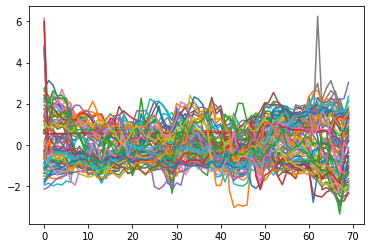

In [74]:
plt.plot(tickers_scaled.T);

# Basic KMeans

  0%|          | 0/9 [00:00<?, ?it/s]

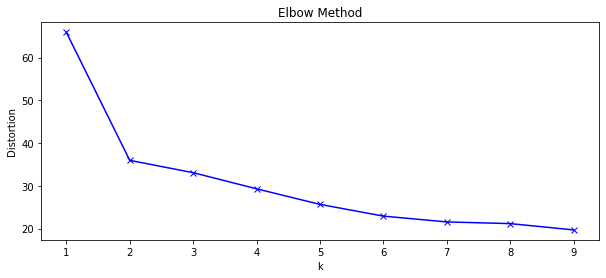

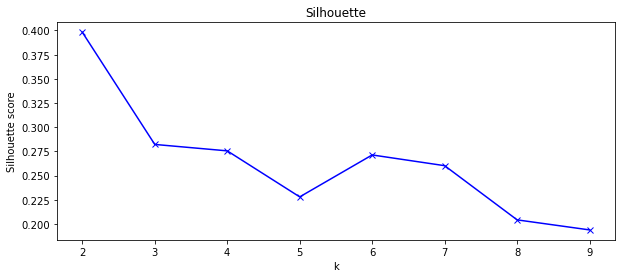

In [75]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [106]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=6, n_jobs=3)

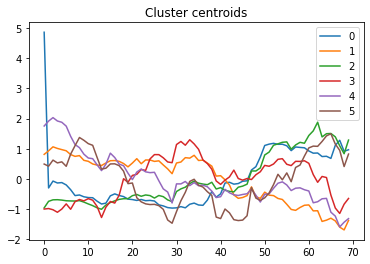

In [107]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [108]:
df_tic['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(df_tic.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Financial Services           7
1       Healthcare                   9
        Technology                   4
        Communication Services       3
        Financial Services           2
2       Technology                  10
        Healthcare                   7
        Consumer Cyclical            3
        Industrials                  2
        Communication Services       1
        Financial Services           1
3       Basic Materials              2
        Financial Services           2
        Healthcare                   2
        Technology                   2
                                     1
        Industrials                  1
4       Technology                   4
        Consumer Cyclical            3
        Consumer Defensive           2
        Financial Services           2
        Communication Services       1
        Industrials                  1
        Real Estate                  1
5       Consumer Cyclical            3
        Technology                   1

In [109]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


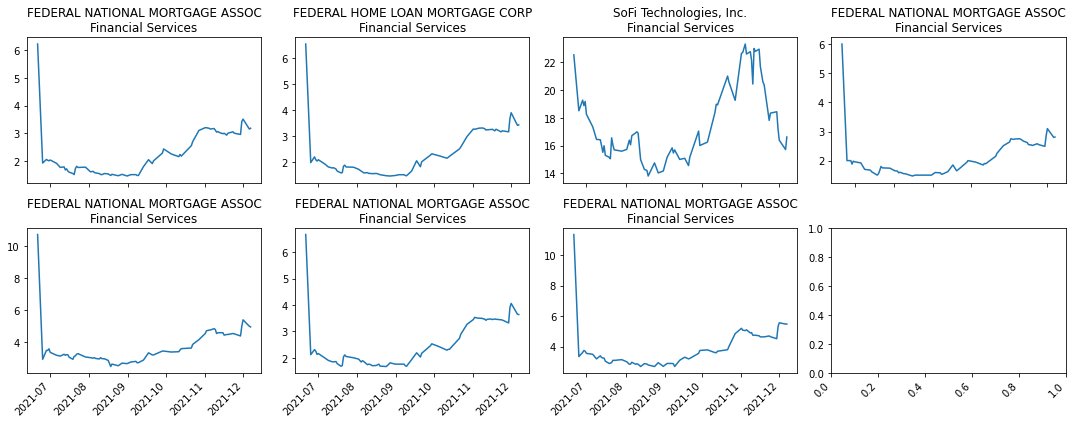

                          Cluster number: 1


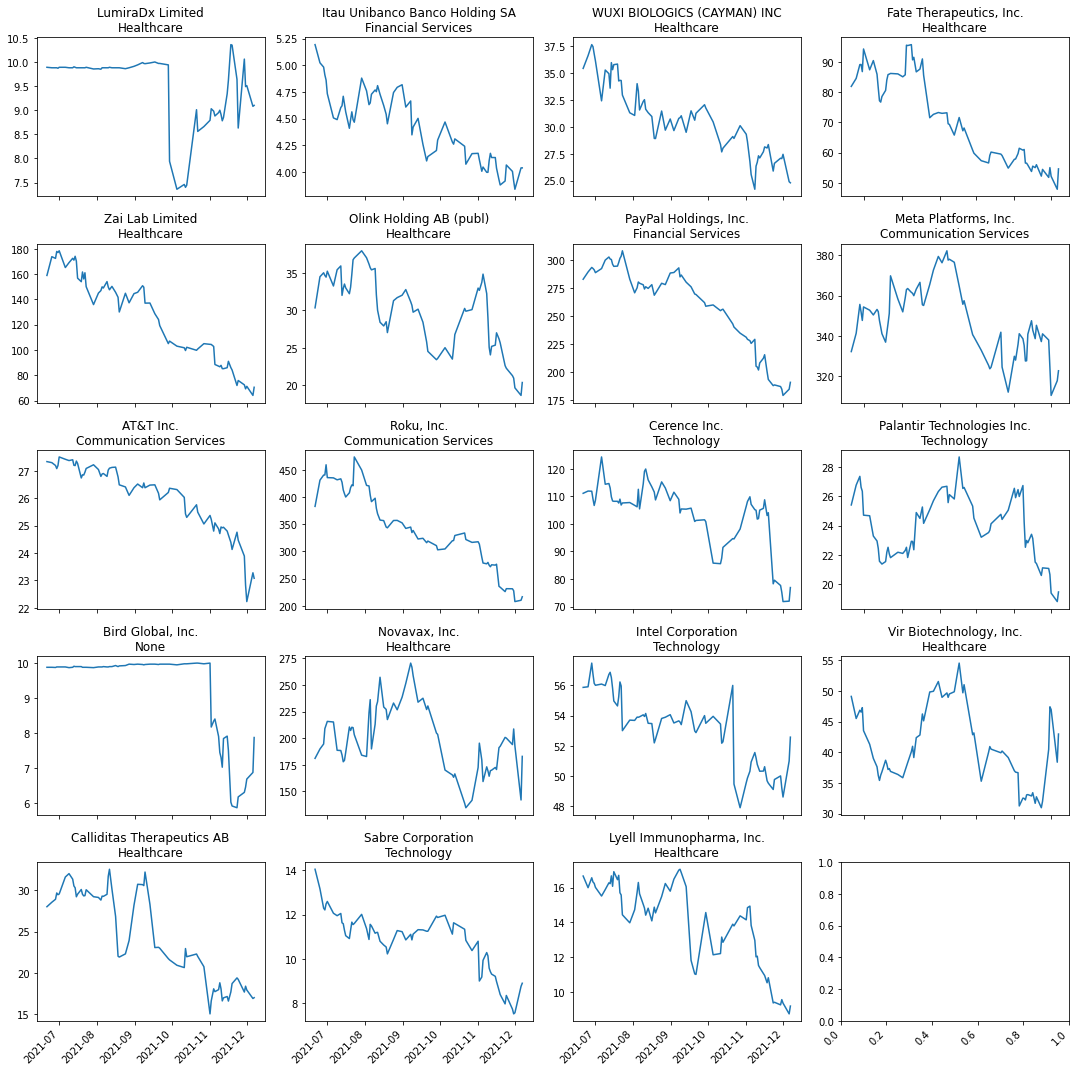

                          Cluster number: 2


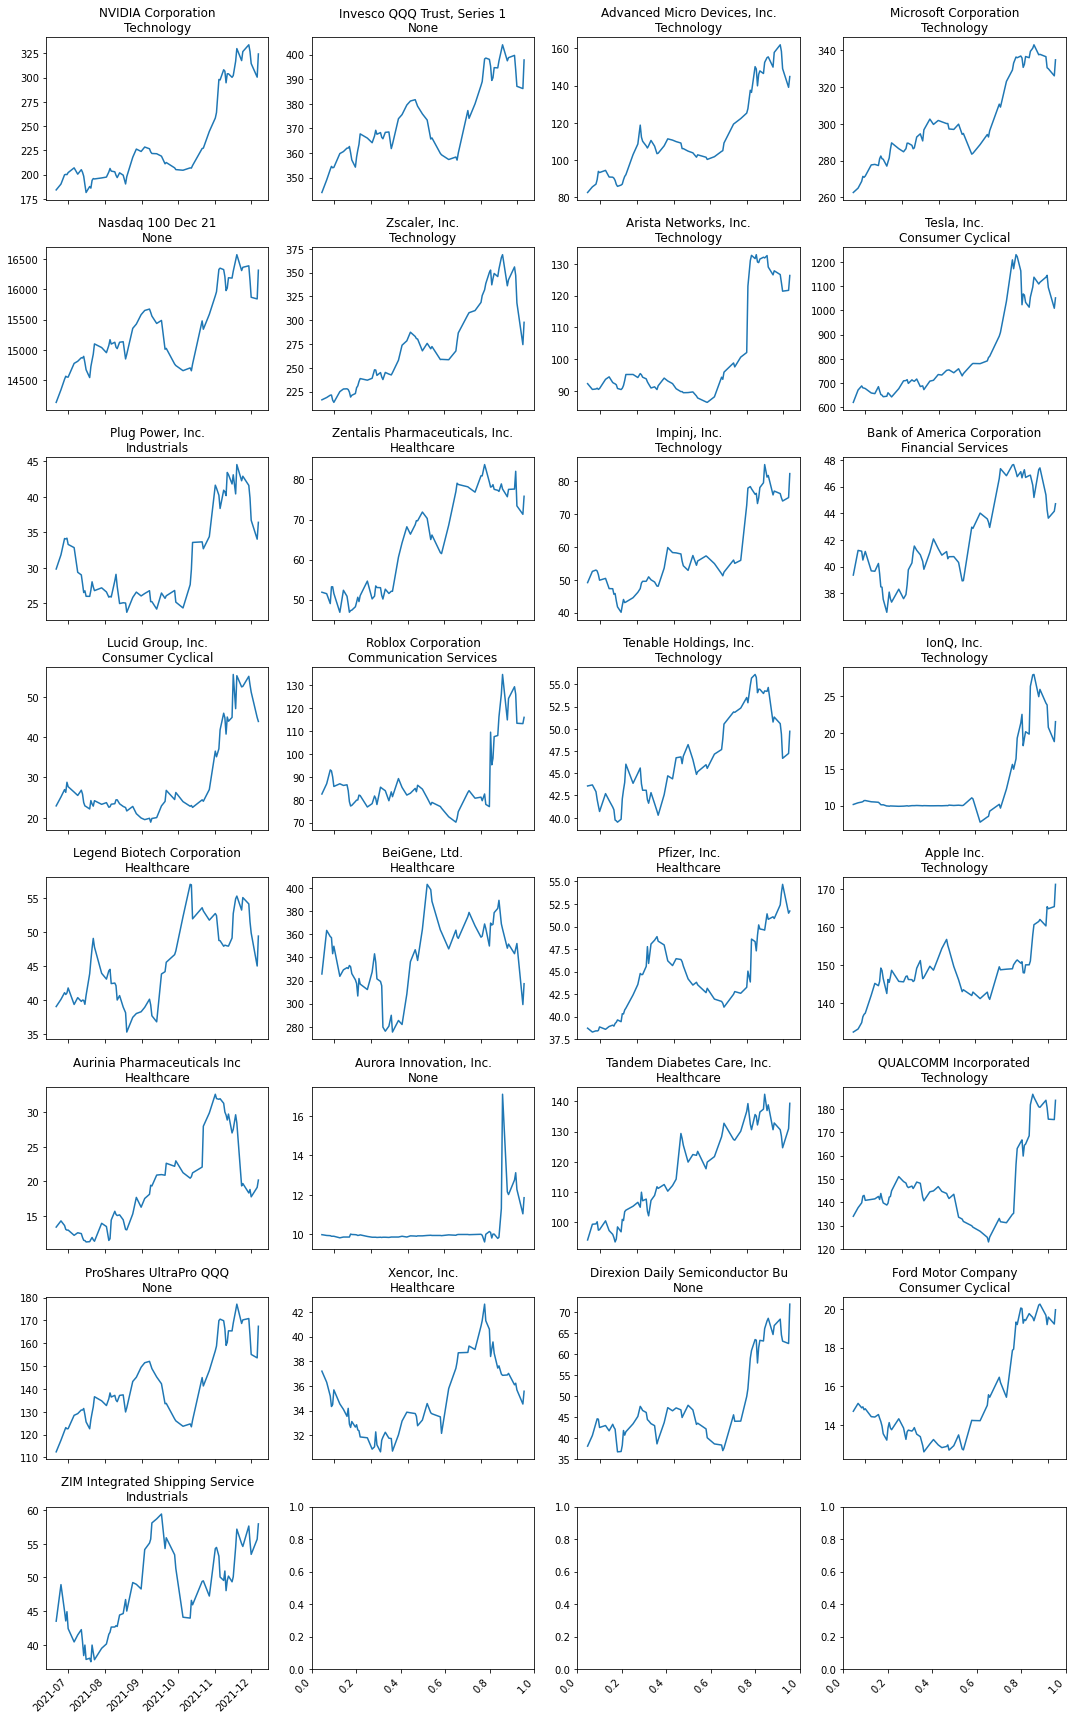

                          Cluster number: 3


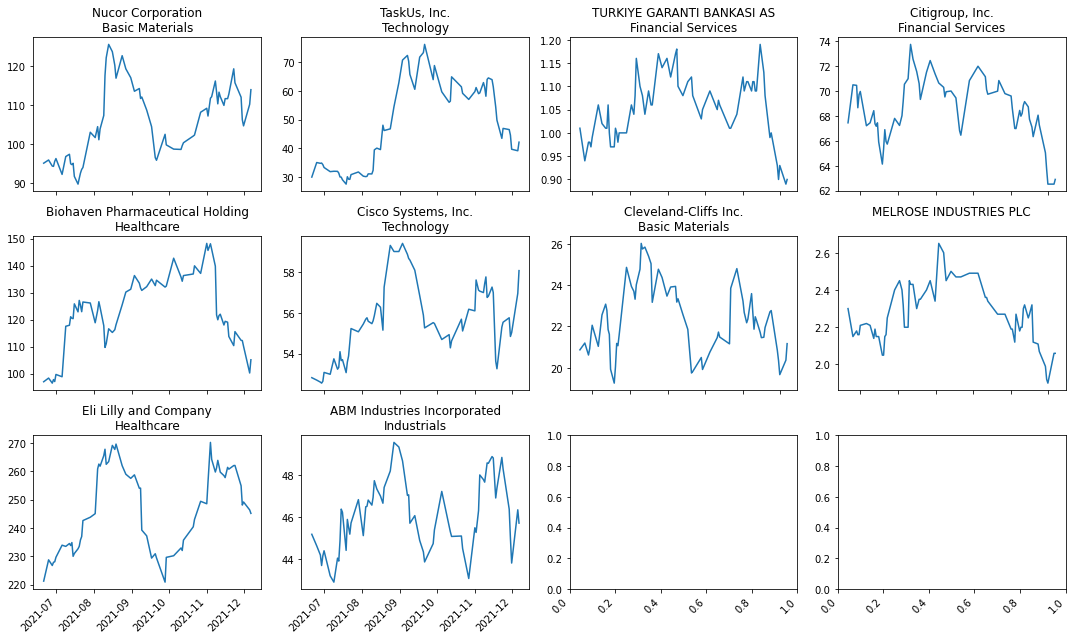

                          Cluster number: 4


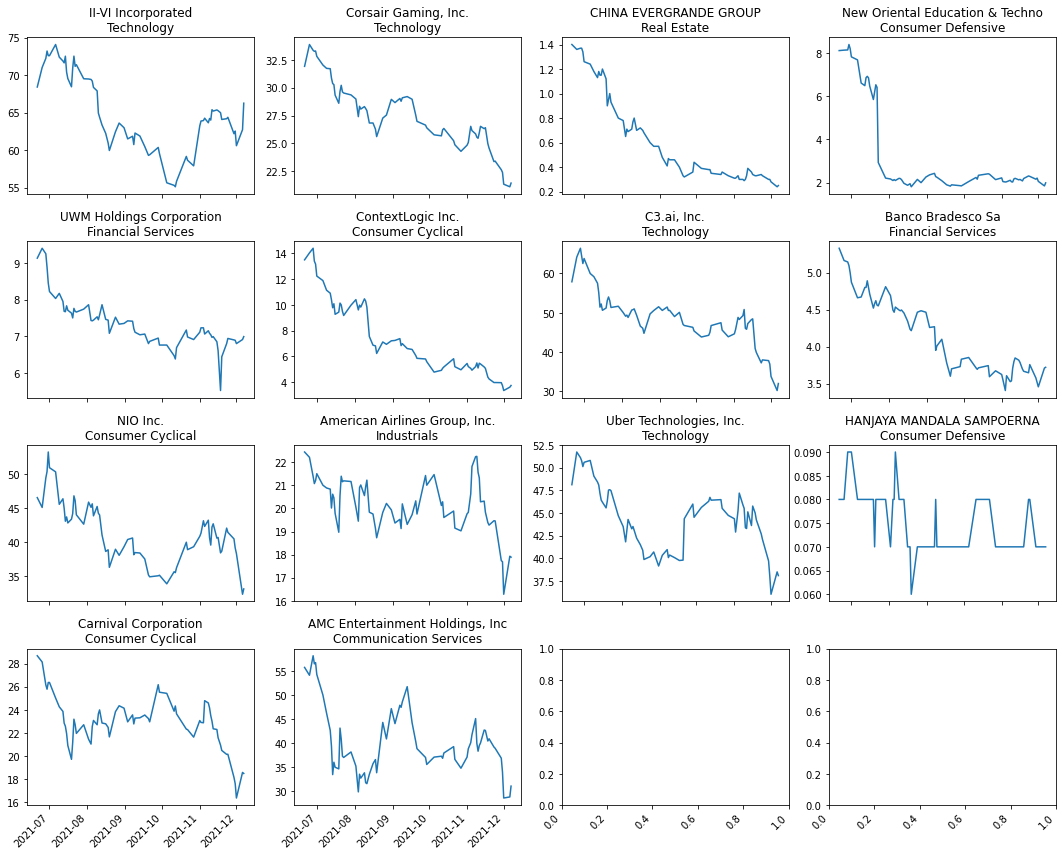

                          Cluster number: 5


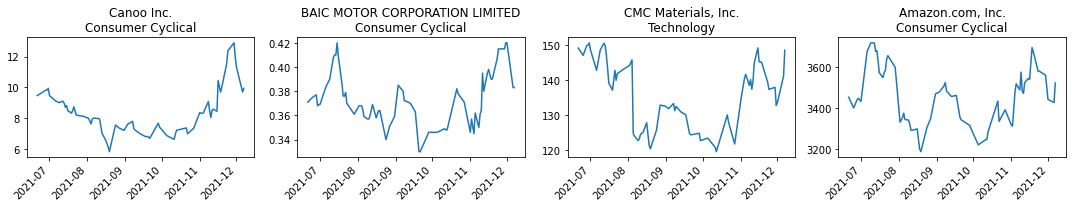

In [110]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(df_tic[df_tic.cluster==cluster])

# DTW

  0%|          | 0/9 [00:00<?, ?it/s]

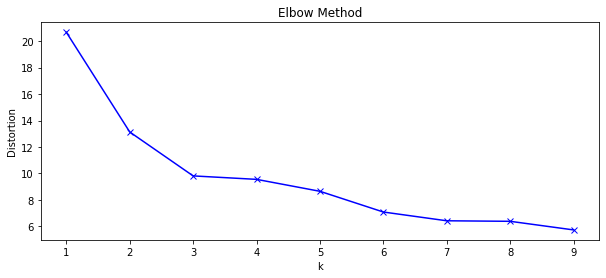

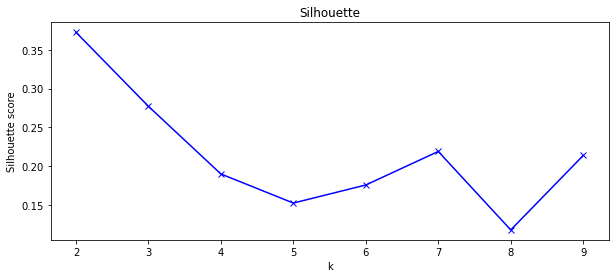

In [86]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [119]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, n_jobs=6)

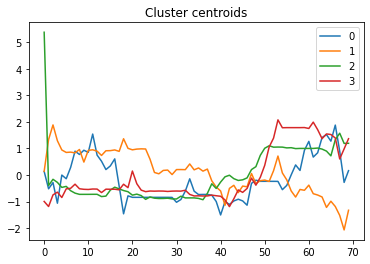

In [120]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [121]:
df_tic['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(df_tic.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Healthcare                   6
        Consumer Cyclical            3
        Basic Materials              2
        Technology                   2
        Financial Services           1
        Industrials                  1
1       Technology                   8
        Healthcare                   7
        Financial Services           6
        Communication Services       4
        Consumer Cyclical            3
        Consumer Defensive           2
                                     1
        Industrials                  1
        Real Estate                  1
2       Financial Services           6
3       Technology                  11
        Healthcare                   5
        Consumer Cyclical            3
        Industrials                  2
        Communication Services       1
        Financial Services           1

                          Cluster number: 0


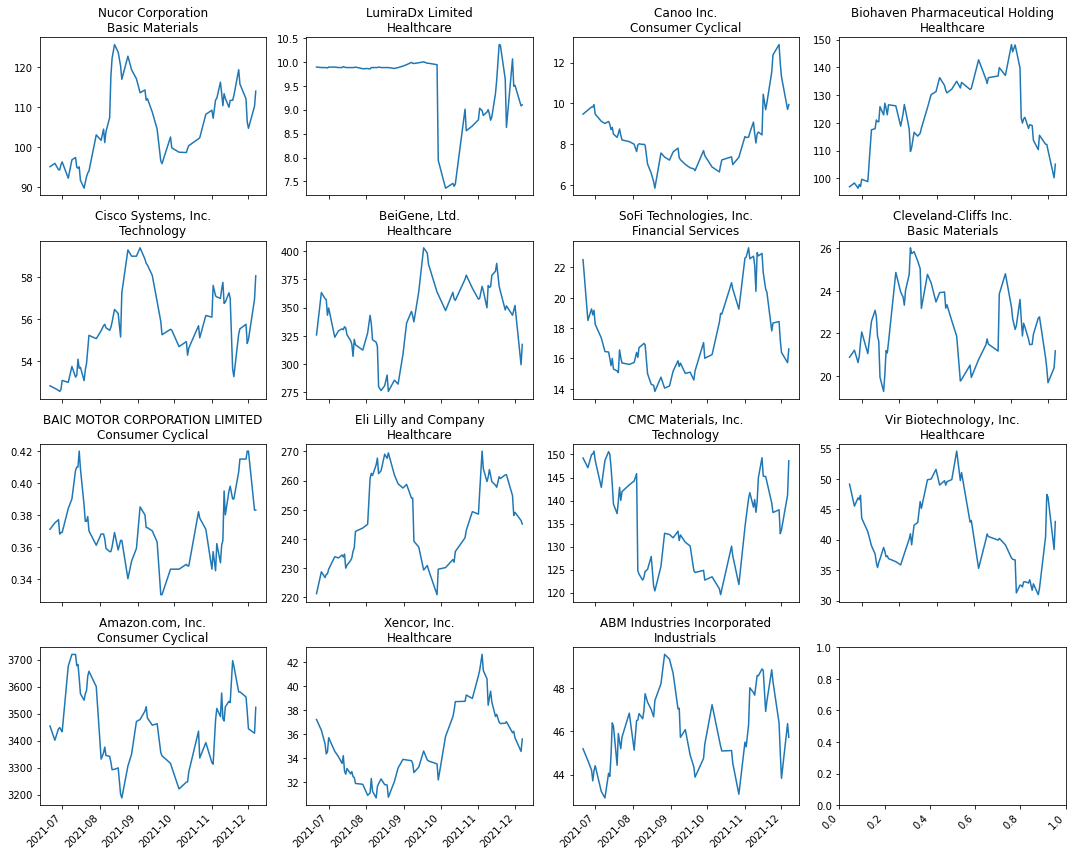

                          Cluster number: 1


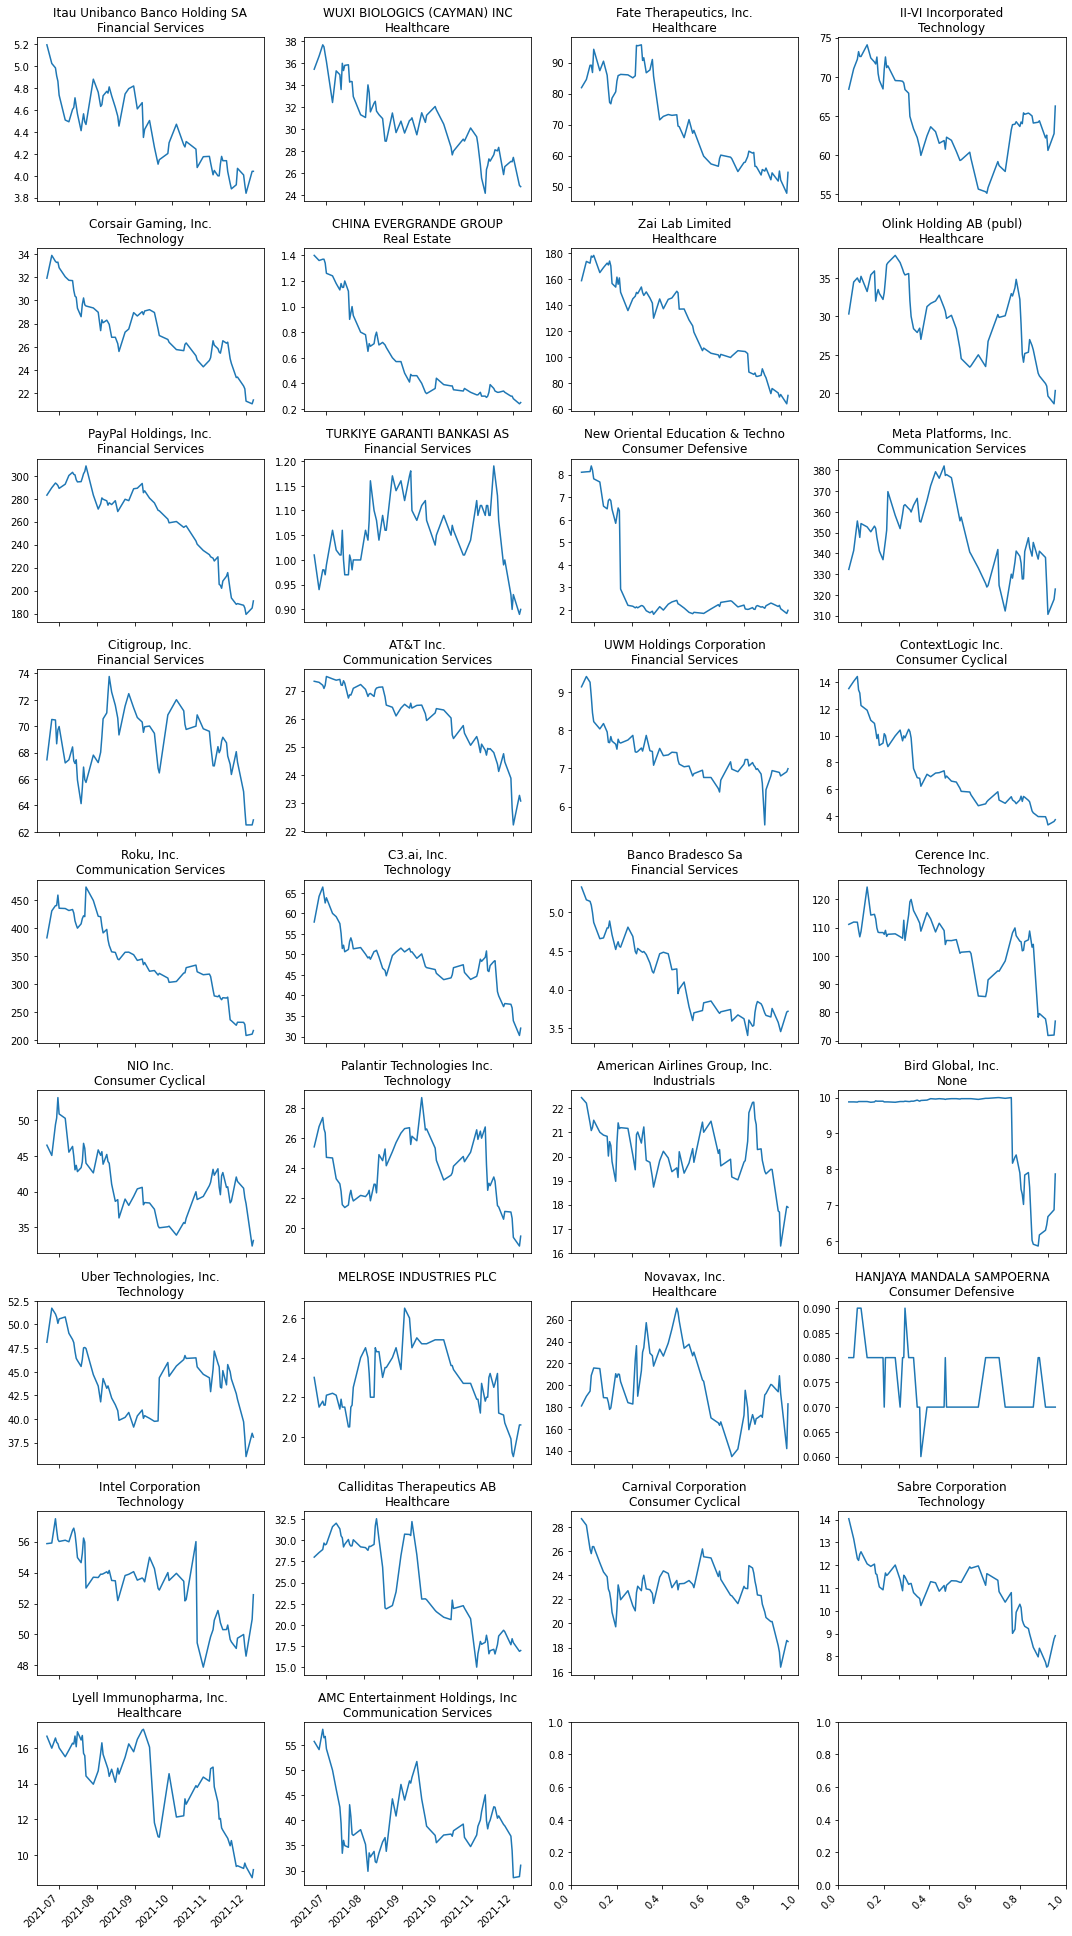

                          Cluster number: 2


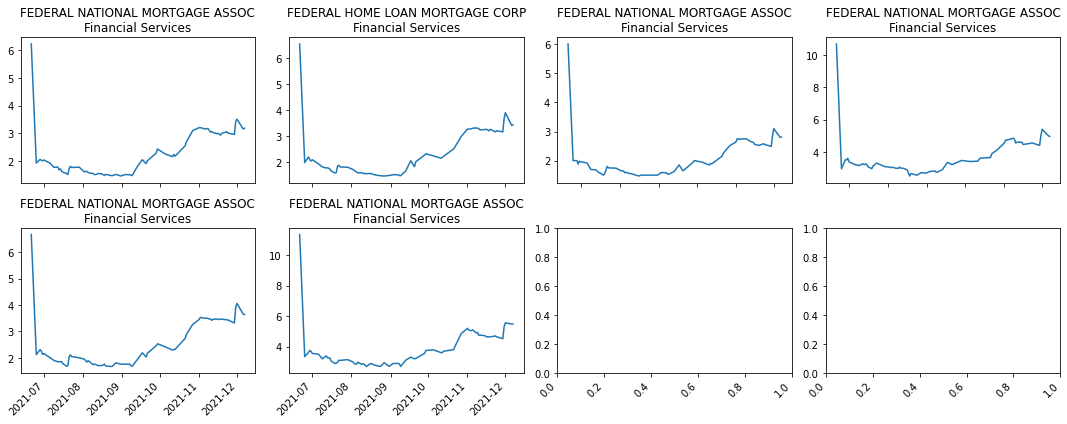

                          Cluster number: 3


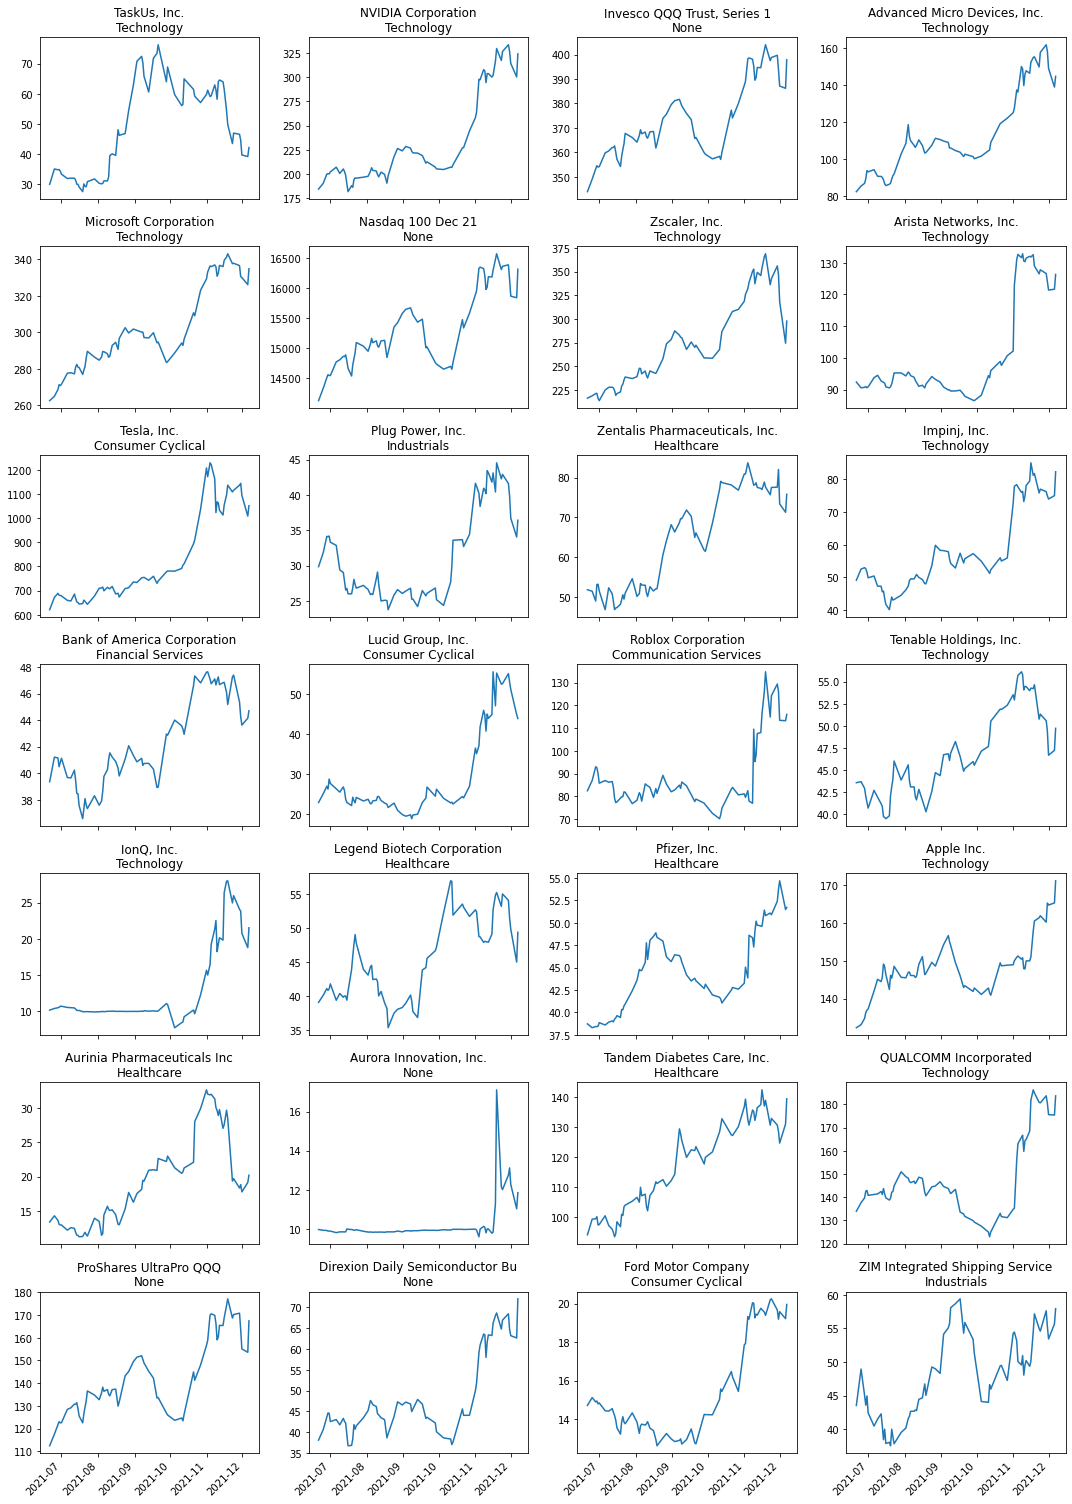

In [122]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(df_tic[df_tic.cluster==cluster])